In [1]:
import numpy as np
import pandas as pd

import math

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_table('data/news_train.txt', names=('label', 'title', 'text'))
df_test = pd.read_table('data/news_test.txt', names=('title', 'text'))
df_test.head()

,title,text
0,В МИД Белоруссии одобрили вынос российского фл...,"Белорусский спортсмен, несший на открытии пара..."
1,Про Хана Соло и Бобу Фетта из «Звездных войн» ...,"Стало известно, кто именно будет центральными ..."
2,В Рунете началась вирусная ICQ-эпидемия,Тысячи пользователей стали жертвой нового ICQ-...
3,Шуховскую башню на Оке признали памятником фед...,Башня конструкции инженера Владимира Шухова в ...
4,Голодец предупредила правительство о последств...,Вице-премьер правительства России Ольга Голоде...


# Preprocessing
## Tokenize text

In [6]:
labels = df['label'].unique()
label_map = {x:i for i,x in enumerate(labels)}

df['label'] = df['label'].map(label_map)

In [7]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")

    #df[text_field] = df[text_field].str.replace(r"[^А-Яа-я0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"[^А-Яа-я0-9.,\-]", " ")
    
    #df[text_field] = df[text_field].str.replace(r"[«\'\`\"]\w+[»\'\`\"]", "quote")
    
    df[text_field] = df[text_field].str.replace(r"[А-Я]. [А-Я]. [А-Я][а-я]+", "FIO")    #names
    df[text_field] = df[text_field].str.replace(r" [А-Я][а-я]+ [А-Я][а-я]+", " FI")
    
    df[text_field] = df[text_field].str.lower()
    
    df[text_field] = df[text_field].str.replace(r"[0-9]", "0")      #numbers to universal token
    df[text_field] = df[text_field].str.replace(r"0+[,.]0+", "0.0")
    
    df[text_field] = df[text_field].str.replace(r"не ", "не_")      #merge не with following word
    
    df[text_field] = df[text_field].str.replace(r"[.,] ", " ")      #del punctuation
    return df

df = standardize_text(df, 'title')
df = standardize_text(df, 'text')

df_test = standardize_text(df_test, 'title')
df_test = standardize_text(df_test, 'text')

df.head()

,label,title,text
0,0,наградит победителей регаты,парусная гонка пройдет в ср...
1,1,матс сундин стал советником тренера сборной шв...,шведский хоккеист fi назначен советником главн...
2,2,брендом года по версии впервые стал город,гран-при конкурса брэнд года получил г...
3,3,цена нефти снизилась после публикации данн...,цена американской нефти на лондонской бирж...
4,3,сбербанк распродаст другим банкирам миллиардны...,сбербанк выставил на продажу долги по 0.0 тыся...


In [8]:
df_test.head()

,title,text
0,в мид белоруссии одобрили вынос российского фл...,белорусский спортсмен несший на открытии парал...
1,про fi и fi из звездных войн снимут два отде...,стало известно кто именно будет центральными г...
2,в рунете началась вирусная -эпидемия,тысячи пользователей стали жертвой нового -...
3,шуховскую башню на оке признали памятником фед...,башня конструкции инженера fi в городе fi обла...
4,голодец предупредила правительство о последств...,вице-премьер правительства fi голодец призвала...


## Get BOF

In [9]:
def get_vocabulary(df):
    bag = {}    #bag og words
    words_count = 0
    words_count_in_labels = [0 for x in labels]
    
    # Process title    
    for i,string in enumerate(df['title'].values):
        label_idx = df['label'].values[i]
        
        for word in string.split():
            words_count += 1
            words_count_in_labels[label_idx] += 1
            
            word = stem(word)            
            if word not in bag:
                bag[word] = 1
            else:
                bag[word] += 1
            
            #bag[word] = [0 for x in labels]    # save how much this word appear for each label
            #bag[word][label_idx] += 1
            
    for i,string in enumerate(df['text'].values):
        label_idx = df['label'].values[i]
        
        for word in string.split():
            words_count += 1
            words_count_in_labels[label_idx] += 1
            
            word = stem(word)            
            if word not in bag:
                bag[word] = 1
            else:
                bag[word] += 1
    
    return bag, words_count, words_count_in_labels

def stem(word):
    #TODO: some sort of stemming or lemmatization
    return word 

bag, wc, wcl = get_vocabulary(df)
print(wc, len(bag))

11150160 471316


## Get Tf-Idf

In [10]:
class TfIdfVectorizer():
    def compute_tf(self, bag):
        tfDict = {}
        for word, count in bag.items():
            tfDict[word] = count / len(bag)
        return tfDict

    def compute_idf(self, bag, docList):
        idfDict = dict.fromkeys(bag.keys(), 0)
        N = len(docList)

        for doc in docList:
            for word in set(doc.split()):
                idfDict[word] += 1

        for word, val in idfDict.items():
            idfDict[word] = math.log(N / float(val)) + 1
        return idfDict

    def compute_tfidf(self, tf, idf, threshold=0.001):
        tfidfDict = {}
        for word, val in tf.items():
            v = val*idf[word]
            if (v > threshold):
                tfidfDict[word] = v
        return tfidfDict
    
    def __init__(self, bag, docList, threshold=0.001):
        tf = self.compute_tf(bag)
        idf = self.compute_idf(bag, docList)
        self.vocabulary = self.compute_tfidf(tf, idf, threshold)
    
    def vectorize_string(self, string):
        vec = dict.fromkeys(self.vocabulary.keys(), 0)
        for word in string.split():
            try:
                vec[word] += self.vocabulary[word]
            except:
                continue
            
        vec = np.array(list(vec.values()))
        vec /= np.linalg.norm(vec)
        
        return vec
    
    def vectorize(self, array):
        v = np.array([self.vectorize_string(x) for x in array])
        return v


tfidf = TfIdfVectorizer(bag, (df['title'] + " " + df["text"]).tolist() , threshold=0.01)
print(len(tfidf.vocabulary))

1360


In [11]:
X_train = (df['title'] + " " + df["text"]).tolist()
X_test = (df_test['title'] + " " + df_test["text"]).tolist()
y_train = df["label"].tolist()

X_train_counts = tfidf.vectorize(X_train)
X_test_counts = tfidf.vectorize(X_test)

In [12]:
X_mean, X_std = X_train_counts.mean(axis=0), X_train_counts.std(axis=0)
X_train_counts = (X_train_counts - X_mean)/X_std
X_test_counts = (X_test_counts - X_mean)/X_std

# Define classifier
Logistic regression with logloss

In [13]:
def accuracy(y, y_pred):
    return sum(y == y_pred) / len(y)

def MSE(y_pred, y):
    return np.mean(np.square(np.subtract(y, y_pred)))

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def ReLU(x):
    return np.clip(x, a_min=0)


def logloss(y, y_pred, eps=1e-15):
    y_p = np.clip(y_pred, eps, 1 - eps)
    return - y*np.log(y_p) - (1-y)*(np.log(1-y_p))

def dlogloss_dy(y, y_pred, eps=1e-15):
    y_p = np.clip(y_pred, eps, 1 - eps)
    return - y*(1/y_p) + (1-y)*1/(1-y_p)

In [14]:
class LogReg():
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y, eta=1e-2, n_classes=10, max_iter=10):
        history = []
        
        N = X.shape[0]
        
        b = np.ones((N,1))          #add bias
        X_bias = np.hstack((X,b))
        
        n_features = X_bias.shape[1]
        
        if self.weights is None:
            self.weights = np.random.randn(n_classes, n_features)
            
        print("Train on ", N, "x", n_features)
        print("Start training")
        for i in range(max_iter):
            running_loss = 0.0
            for j in range(N):
                
                sample, label = X_bias[j], y[j]
                
                #label 2 vector
                y_true = np.zeros(n_classes)
                y_true[label] = 1
                
                #calculate prediction
                z = np.matmul(self.weights, sample.T)
                y_pred = sigmoid(z)
                
                loss = logloss(y_true, y_pred)
                running_loss += np.mean(loss)
                
                #calculate gradient
                dsigm_dz = y_pred * (1 - y_pred)
                grad = np.outer(dlogloss_dy(y_true, y_pred) * dsigm_dz, sample)
                
                self.weights -= eta * grad
                
                if j % 20000 == 19999:
                    history.append(running_loss/1000)
                    #print("[{} - {}] loss: {:.5}".format(i,j,running_loss/1000))
                    running_loss = 0.0
        return history
    
    def predict(self, X):
        N = X.shape[0]
        
        b = np.ones((N,1))          #add bias
        X_bias = np.hstack((X,b))
        
        y = np.zeros(N)
        
        for i,sample in enumerate(X_bias):
            z = np.matmul(self.weights, sample.T)
            y_pred = sigmoid(z)
            label = y_pred.argmax()
            y[i] = label

        return y

## Train classifier using SGD

Train on  60000 x 1361
Start training


/media/andre6o6/aux/anaconda3/envs/nn/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


loss =  5.930292868846412


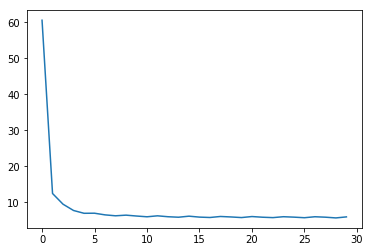

In [15]:
clf = LogReg()
history = clf.fit(X_train_counts, y_train)
plt.plot(history)
print("loss = ", history[-1])

Train on  60000 x 1361
Start training
loss =  1.8535808862736474


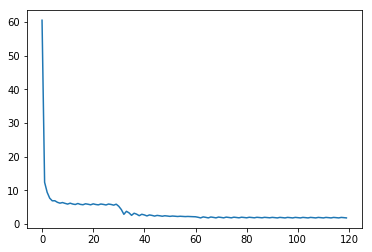

In [20]:
h2 = clf.fit(X_train_counts, y_train, eta=1e-5)
history.extend(h2)
plt.plot(history)
print("loss = ", history[-1])

In [35]:
y_pred = clf.predict(X_test_counts)

inv_map = {v: k for k, v in label_map.items()}
y_pred = [inv_map[int(x)] for x in y_pred]

import os
with open(os.path.join('data', 'submission.txt'), 'w') as f:
    f.write('\n'.join(y_pred))